# Lectures on Machine Learning for Strong Gravity
## Lecture 3: Learning Orbital Dynamics and Fourier Neural Operators

To test it, simply press Ctrl+Enter sequentially in each cell, or click on the small icons on the left with the "play" symbol.

<br>

<a href="https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture3_Learning_Orbital_Dynamics_and_Fourier_Neural_Operators.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### In this lecture, you will learn:
1. How we can learn the corrections to the Newtonian equations of motion by analyzing gravitational waves.<br>
  Original paper:<br>
  
 - Brendan Keith, Akshay Khadse, and Scott E. Field, <i>Learning orbital dynamics of binary black hole systems from gravitational wave measurements</i>, Phys. Rev. Research 3, 043101, 2021. https://arxiv.org/abs/2102.12695
 
 
2. How we can use Fourier Neural Operators to learn the solution of a differential equation from examples.<br>
  Original papers:<br>
  
 - Li, Z., Kovachki, N., Azizzadenesheli, K., Liu, B., Bhattacharya, K., Stuart, A., and Anandkumar A. , “Fourier Neural Operator for Parametric Partial Differential Equations”, ICLR, 2021. https://arxiv.org/abs/2010.08895
  
 - Kovachki, N., Li, Z., Liu, B., Azizzadenesheli, K., Bhattacharya, K., Stuart, A., and Anandkumar A. , “Neural Operator: Learning Maps Between Function Spaces”, , JMLR, 2021. https://arxiv.org/abs/2108.08481.

<br>

# 1. Learning Orbital Dynamics

The equation for a Keplerian orbit is 

$$r = \frac{p}{1+e \cos\chi}.$$

In terms of the variables ($\chi$, $\phi$), the Newtonian differential equations are

$$\dot \phi = \dot \chi = \frac{(1 + e \cos \chi)^2}{M p^{3/2}}.$$

Let's add a correction to these equations of motion by a neural network, in the form

$$\dot \phi = \frac{(1 + e \cos \chi)^2}{M p^{3/2}} \left[1 + F_1(\chi, p, e)\right],$$
$$\dot \chi = \frac{(1 + e \cos \chi)^2}{M p^{3/2}} \left[1 + F_1(\chi, p, e)\right].$$

Can we fit the correction functions $F_1$ and $F_2$ by comparing the waveform with a Schwarzschild EMRI? We will compute the waveform to be

$$h^{22} = \sqrt{\frac{4\pi}{5}} \left(\ddot I_{xx} - 2i \ddot I_{xy} - \ddot I_{yy}\right),$$

where $I_{ab}$ is the trace-free mass quadrupole tensor. Ideally, we should recover the geodesic equations for Schwarzschild:

$$\dot \phi = \frac{(p -2 -2e\cos \chi)(1 + e \cos \chi)^2}{M p^{3/2}\sqrt{(p-2)^2-4e^2}},$$

$$\dot \chi = \frac{(p -2 -2e\cos \chi)(1 + e \cos \chi)^2\sqrt{p -6 -2e\cos\chi}}{M p^{3/2}\sqrt{(p-2)^2-4e^2}}.$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec

from torchdiffeq import odeint

In [2]:
def SchwGeo(t, y):
    phi = y[:,0]
    chi = y[:,1]

    dphi = (p-2-2*e*torch.cos(chi)) * (1+e*torch.cos(chi))**2 / (M * p**1.5 * torch.sqrt((p-2)**2 - 4*e**2))
    dchi = dphi * torch.sqrt(p - 6 - 2*e*torch.cos(chi)) / torch.sqrt(p)

    return torch.stack((dphi, dchi), 1)

def NewtGeo(t, y):
    phi = y[:,0]
    chi = y[:,1]

    dphi = (1 + e*torch.cos(chi))**2 / (M * p**1.5)
    dchi = dphi
    
    return torch.stack((dphi, dchi), 1)

def waveform(y, dy, ddy):
    phi   = y[:,0]
    chi   = y[:,1]
    dphi  = dy[:,0]
    dchi  = dy[:,1]
    ddphi = ddy[:,0]
    ddchi = ddy[:,1]
    
    r = p * M / (1 + e * torch.cos(chi))
    x = r * torch.cos(phi)
    y = r * torch.sin(phi)
    
    dx = -((dphi*M*p*torch.sin(phi))/(1 + e*torch.cos(chi))) + (dchi*e*M*p*torch.cos(phi)*torch.sin(chi))/(1 + e*torch.cos(chi))**2
    dy = (M*p*(dphi*torch.cos(phi)*(1 + e*torch.cos(chi)) + dchi*e*torch.sin(phi)*torch.sin(chi)))/(1 + e*torch.cos(chi))**2
    
    ddx = -((M*p*(dphi**2*torch.cos(phi)*(1 + e*torch.cos(chi))**2 + (dchi**2*e*torch.cos(phi)*(-2*torch.cos(chi) + e*(-3 + torch.cos(2*chi))))/2. + 2*dphi*dchi*e*(1 + e*torch.cos(chi))*torch.sin(phi)*torch.sin(chi) + (1 + e*torch.cos(chi))*(ddphi*(1 + e*torch.cos(chi))*torch.sin(phi) - ddchi*e*torch.cos(phi)*torch.sin(chi))))/(1 + e*torch.cos(chi))**3)
    ddy = (M*p*(-(dphi**2*(1 + e*torch.cos(chi))**2*torch.sin(phi)) + (dchi**2*e*(3*e + 2*torch.cos(chi) - e*torch.cos(2*chi))*torch.sin(phi))/2. + 2*dphi*dchi*e*torch.cos(phi)*(1 + e*torch.cos(chi))*torch.sin(chi) + (1 + e*torch.cos(chi))*(ddphi*torch.cos(phi)*(1 + e*torch.cos(chi)) + ddchi*e*torch.sin(phi)*torch.sin(chi))))/(1 + e*torch.cos(chi))**3
    
    ddIxx =  (2/3) * (2 * dx**2 - dy**2 + 2 * x*ddx - y*ddy)
    ddIyy = -(2/3) * (dx**2 - 2 * dy**2 + x*ddx - 2 * y*ddy)
    
    return np.sqrt(4*np.pi/5) * (ddIxx - ddIyy)
    

In [3]:
class NetGeo(nn.Module):
    def __init__(self):
        super(NetGeo, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.GELU(),
            nn.Linear(32, 32),
            nn.GELU(),
            nn.Linear(32, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.weight,val=0)
                nn.init.constant_(m.bias, val=0)
        
    def forward(self, t, y):
        yc = torch.cos(y[:,[1]])
        return NewtGeo(t, y) * (1 + self.net(yc))


class GetOrbit(nn.Module):
    def __init__(self, func):
        super(GetOrbit, self).__init__()
        self.func = func
    
    def forward(self, t, y):
        y = odeint(self.func, y0, t, method='dopri5').reshape(t.size()[0],2).to(device)
        phi = y[:,0]
        chi = y[:,1]
        r   = p * M / (1 + e * torch.cos(chi))
        
        return torch.stack((r * torch.cos(phi), r * torch.sin(phi)), 1)

class GetWaveform(nn.Module):
    def __init__(self, func):
        super(GetWaveform, self).__init__()
        self.func = func
    
    def forward(self, t, y):
        h = t[1] - t[0]
        y = odeint(self.func, y0, t, method='dopri5').reshape(t.size()[0],2).to(device)
        dy = self.func(t, y)
        ddy = (torch.roll(dy, -1, dims=0) - torch.roll(dy, 1, dims=0)) / (2*h)
        ddy[0]  = (dy[1] - dy[0]) / h
        ddy[-1] = (dy[-1] - dy[-2]) / h
        
        return  waveform(y, dy, ddy)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

p  = torch.tensor(100., device = device)
e  = torch.tensor(0.5, device = device)
M  = torch.tensor(1., device = device)

y0 = torch.tensor([[0., np.pi]], device = device)
t_train  = torch.linspace(0., 50000., 1000, device = device)

true_y_fun     = GetWaveform(SchwGeo)
true_orbit_fun = GetOrbit(SchwGeo)
true_y         = true_y_fun(t_train, y0)

netGeo         = NetGeo().to(device)
pred_y_fun     = GetWaveform(netGeo)
pred_orbit_fun = GetOrbit(netGeo)

optimizer = optim.Adam(netGeo.parameters(), lr=1e-3)

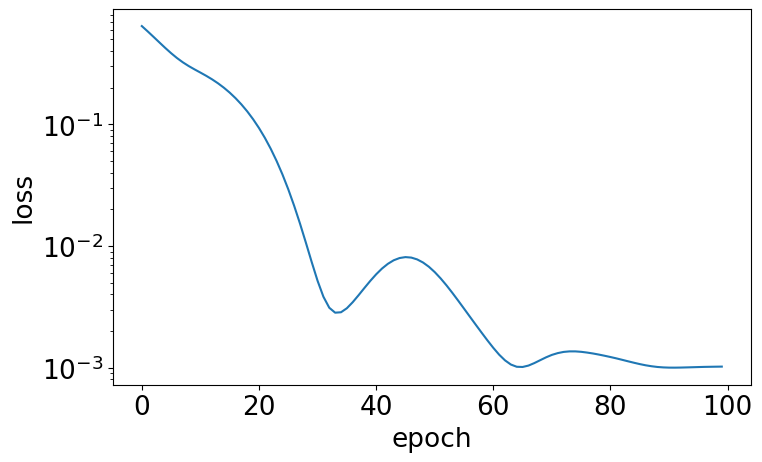

In [5]:
fig, ax = plt.subplots(1,1, figsize = (8, 5));
font = {'size'   : 19}
plt.rc('font', **font)

loss_hist = []

for epoch in range(100):
    try:
        optimizer.zero_grad()

        pred_y = pred_y_fun(t_train, y0)
        loss = torch.sum((pred_y - true_y)**2)

        loss.backward()
        loss_hist.append(loss.item())
        optimizer.step()
        
        ax.cla()
        ax.set_yscale('log')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.plot(loss_hist)
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
        
    except KeyboardInterrupt:
        break

In [6]:
t_test  = torch.linspace(0., 300000., 6000, device = device)

true_y_train = true_y_fun(t_train, y0).cpu().detach().numpy()
true_y_test  = true_y_fun(t_test, y0).cpu().detach().numpy()
pred_y_test  = pred_y_fun(t_test, y0).cpu().detach().numpy()

true_orbit_train = true_orbit_fun(t_train, y0).cpu().detach().numpy()
true_orbit_test  = true_orbit_fun(t_test, y0).cpu().detach().numpy()
pred_orbit_test  = pred_orbit_fun(t_test, y0).cpu().detach().numpy()

hm_side = 100
test_ang = np.linspace(0, 2*np.pi, hm_side)
test_phi, test_chi = np.meshgrid(test_ang, test_ang)
hm_angles  = torch.tensor(np.concatenate([[test_phi.reshape(hm_side**2)], \
                                          [test_chi.reshape(hm_side**2)]]).transpose().astype('float32')).to(device)
hm_times   = torch.zeros(hm_side**2).to(device)
true_eom   = SchwGeo(hm_times, hm_angles)
learnt_eom = netGeo(hm_times, hm_angles)
rel_err    = (learnt_eom - true_eom) / true_eom

phi_dot    = rel_err[:,0].cpu().detach().numpy().reshape(hm_side,hm_side)
chi_dot    = rel_err[:,1].cpu().detach().numpy().reshape(hm_side,hm_side)

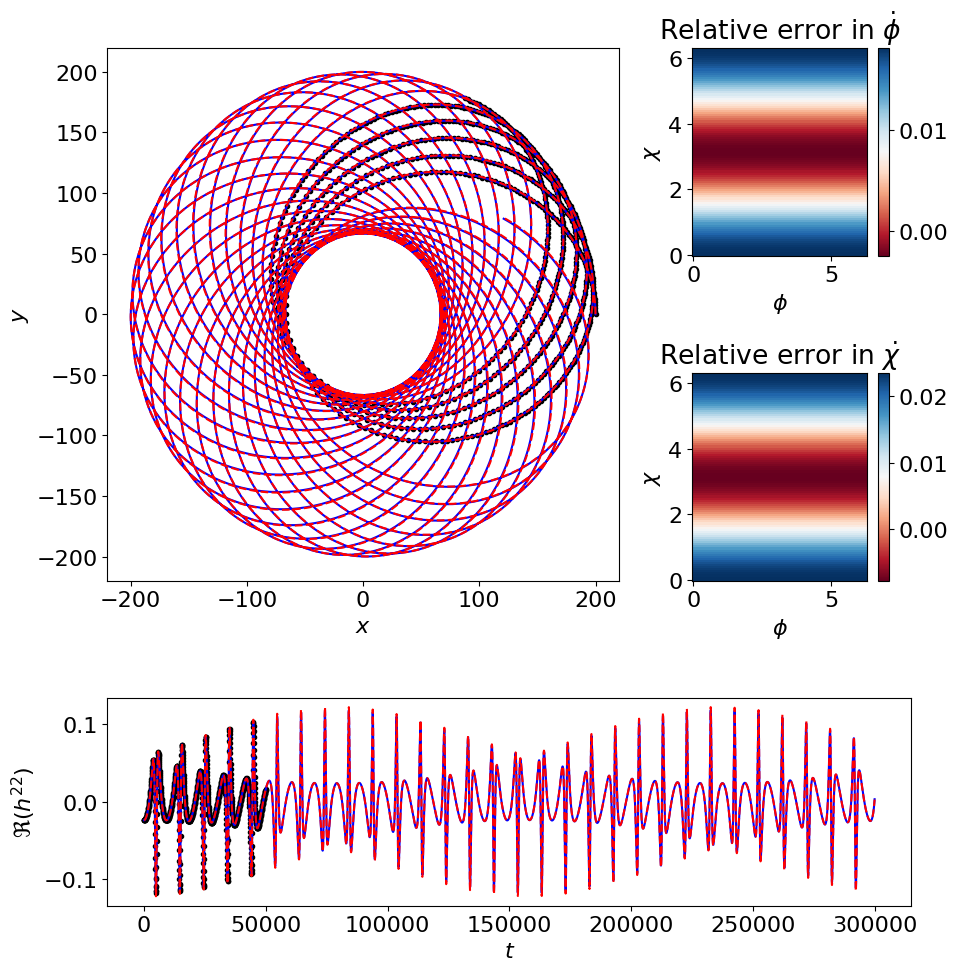

In [7]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize = (10, 10))
font = {'size'   : 16}
plt.rc('font', **font)
# set up subplot grid
gridspec.GridSpec(3,3)

# Orbits subplot
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
plt.plot(true_orbit_train[:,0], true_orbit_train[:,1], '.', color = 'black')
plt.plot(true_orbit_test[:,0], true_orbit_test[:,1], color = 'blue')
plt.plot(pred_orbit_test[:,0], pred_orbit_test[:,1], '--', color = 'red')
plt.xlabel('$x$')
plt.ylabel('$y$')

# Waveform subplot
plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)
plt.plot(t_train.cpu().detach().numpy(), true_y_train, '.', color = 'black')
plt.plot(t_test.cpu().detach().numpy(), true_y_test, color = 'blue')
plt.plot(t_test.cpu().detach().numpy(), pred_y_test, '--', color = 'red')
plt.xlabel('$t$')
plt.ylabel('$\Re(h^{22})$')

# Error in phi
plt.subplot2grid((3,3), (0,2))
plt.title('Relative error in $\dot \phi$')
plt.pcolormesh(test_phi, test_chi, phi_dot, cmap='RdBu', shading='auto')
plt.colorbar()
plt.xlabel('$\phi$')
plt.ylabel('$\chi$')

# Error in chi
plt.subplot2grid((3,3), (1,2))
plt.title('Relative error in $\dot \chi$')
plt.pcolormesh(test_phi, test_chi, chi_dot, cmap='RdBu', shading='auto')
plt.colorbar()
plt.xlabel('$\phi$')
plt.ylabel('$\chi$')

fig.tight_layout()

# 2. Fourier Neural Operators

Fourier Neural operators learn mappings between funtion spaces. Some useful examples could be:

 - State at $t=0$    $\longrightarrow$    State at $t = 10$
 - Source term for the Posson equation     $\longrightarrow$    Solution of the equation
 
These are learnt by looking at many examples, solved by other methods.<br>

-------------------------

In our case, we will use the example (including Python package and dataset) provided by https://neuraloperator.github.io/dev/auto_examples/models/plot_FNO_darcy.html#sphx-glr-auto-examples-models-plot-fno-darcy-py

The equation we want to solve is for Darcy flow:

$$\vec \nabla \cdot \left[a(x,y)\, \nabla u(x,y) \, \right] = 0$$

on the unit square, setting $u = 0$ at the boundary. The Fourier Neural operator learns the mapping 

$$a(x,y) \longrightarrow u(x,y)$$

<br>

In [8]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('You are now using:', device)

You are now using: cuda:0


In [15]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [10]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2).to(device)

optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')


Our model has 1192801 parameters.


In [11]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=0.65, avg_loss=0.6110, train_err=19.0947
Eval: 16_h1=0.4046, 16_l2=0.2693, 32_h1=0.5945, 32_l2=0.2899
[3] time=0.51, avg_loss=0.2145, train_err=6.7032
Eval: 16_h1=0.2214, 16_l2=0.1468, 32_h1=0.5063, 32_l2=0.1885
[6] time=0.52, avg_loss=0.1947, train_err=6.0846
Eval: 16_h1=0.2214, 16_l2=0.1507, 32_h1=0.4728, 32_l2=0.1840
[9] time=0.40, avg_loss=0.1519, train_err=4.7473
Eval: 16_h1=0.2013, 16_l2=0.1227, 32_h1=0.4990, 32_l2=0.1649
[12] time=0.39, avg_loss=0.1564, train_err=4.8879
Eval: 16_h1=0.2026, 16_l2=0.1229, 32_h1=0.5202, 32_l2=0.1741
[15] time=0.39, avg_loss=0.1310, train_err=4.0949
Eval: 16_h1=0.1964, 16_l2=0.1114, 32_h1=0.5007, 32_l2=0.1603
[18] time=0.40, avg_loss=0.1249, train_err=3.9026
Eval: 16_h1=0.2050, 16_l2=0.1231, 32_h1=0.4991, 32_l2=0.1660


{'train_err': 3.0669768303632736,
 'avg_loss': 0.09814325857162476,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.40522789699934947}

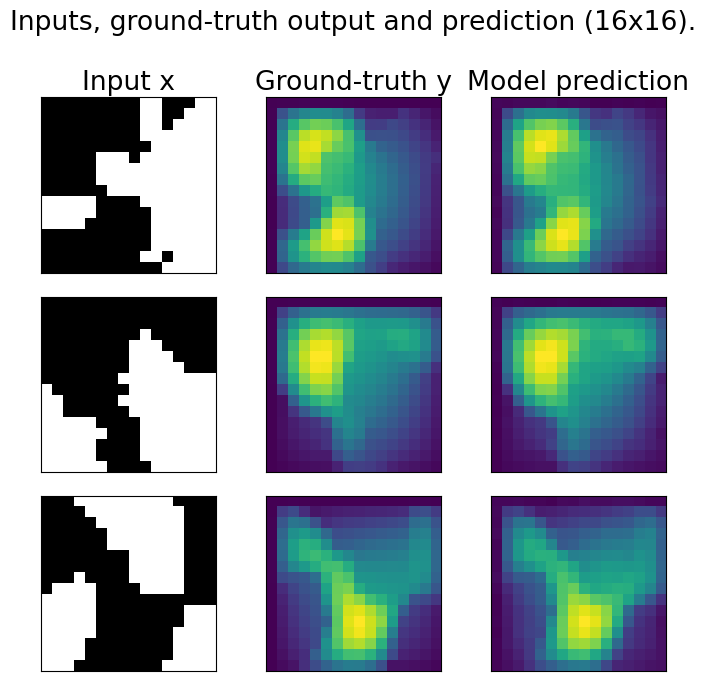

In [12]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()

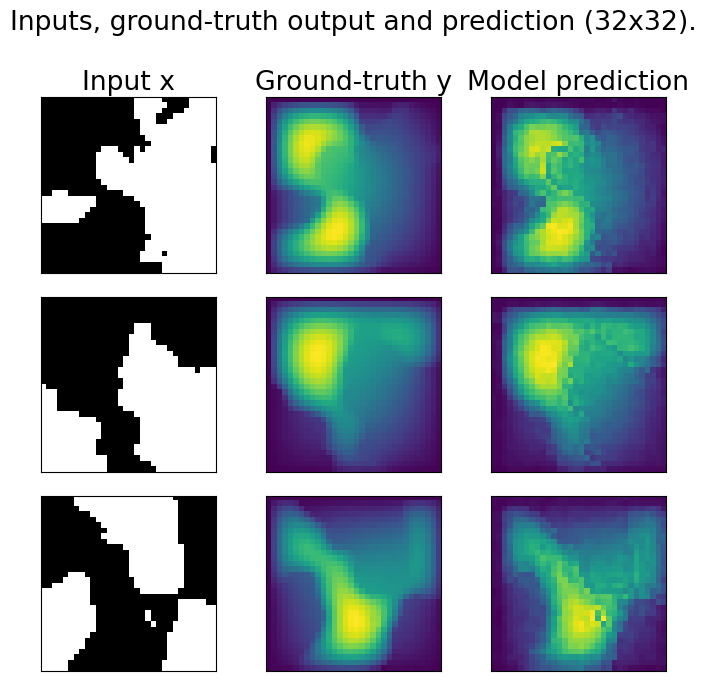

In [13]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()